In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

In [2]:
# Directory containing the "brain_tumor_dataset" folder
directory = "data"

# Collect file paths and labels from subfolders
filepaths = []
labels = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepaths.append(img_path)
        labels.append(fold)

# Create DataFrame from collected data
file_path_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
df_train = pd.concat([file_path_series, label_series], axis=1)

In [3]:
# Head
df_train

,filepath,label
0,data\no\1 no.jpeg,no
1,data\no\10 no.jpg,no
2,data\no\11 no.jpg,no
3,data\no\12 no.jpg,no
4,data\no\13 no.jpg,no
...,...,...
248,data\yes\Y95.jpg,yes
249,data\yes\Y96.jpg,yes
250,data\yes\Y97.JPG,yes
251,data\yes\Y98.JPG,yes


In [4]:
from sklearn.model_selection import train_test_split

# Spliting in Train and Dummy 
train_df , dummy_df = train_test_split(df_train ,train_size = 0.8 , shuffle = True ,random_state = 42 )
# Spliting in Validation and Test From Dummy 
valid_df , test_df = train_test_split(dummy_df ,test_size= 0.5 , shuffle = True ,random_state = 42)

In [5]:
# Shape
print(f"The shape of The Train data is: {train_df.shape}")
print(f"The shape of The Validation data is: {valid_df.shape}")
print(f"The shape of The Test data is: {test_df.shape}")

The shape of The Train data is: (202, 2)
The shape of The Validation data is: (25, 2)
The shape of The Test data is: (26, 2)


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and test data generator without augmentation
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32


# Flow from dataframe or directory, ensuring binary class_mode
print("Training Data")
train_ds = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

print("Validation Data")
validation_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

print("Test Data")
test_ds = validation_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Training Data
Found 202 validated image filenames belonging to 2 classes.
Validation Data
Found 25 validated image filenames belonging to 2 classes.
Test Data
Found 26 validated image filenames belonging to 2 classes.


In [8]:
# Test the training data generator
print("Testing Training Data Generator")
x_train, y_train = next(iter(train_ds))
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Test the validation data generator
print("Testing Validation Data Generator")
x_valid, y_valid = next(iter(validation_ds))
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

Testing Training Data Generator
x_train shape: (32, 256, 256, 3)
y_train shape: (32,)
Testing Validation Data Generator
x_valid shape: (25, 256, 256, 3)
y_valid shape: (25,)


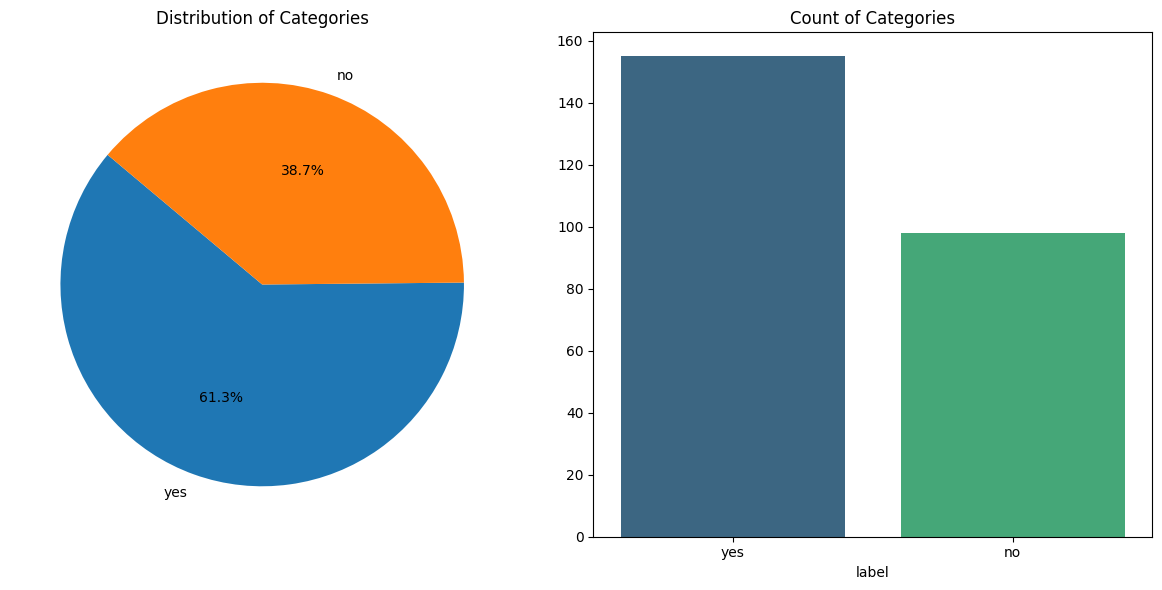

In [9]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

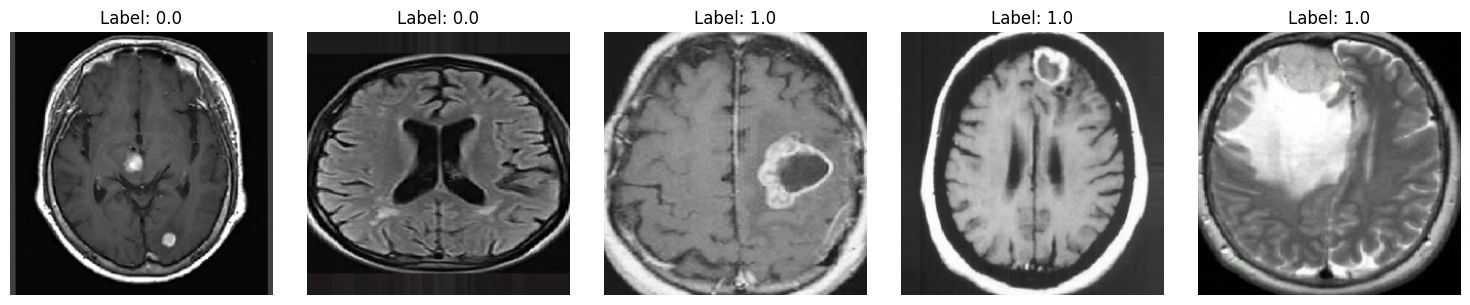

In [10]:
# Function to select and display random images
def display_random_images(generator, num_images):
    # Get batch of images and labels
    batch = next(generator)

    # Select random images from the batch
    selected_indices = random.sample(range(len(batch[0])), min(num_images, len(batch[0])))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, idx in enumerate(selected_indices):
        image = batch[0][idx]  # Get the image array from batch
        label = batch[1][idx]  # Get the corresponding label
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")  # Set label as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Assuming train_generator is your NumpyArrayIterator for the training set
# Display 5 random images from the training set
display_random_images(train_ds, 5)

In [11]:
# Define the class labels for brain tumor classification
class_labels = train_ds.class_indices

# Print the class labels
print(f'Class labels: {class_labels}')

Class labels: {'no': 0, 'yes': 1}


In [12]:
from tensorflow.keras.applications import Xception 

In [13]:
conv_base = Xception (
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

In [14]:
# Build Model
model = Sequential()

# Base Model
model.add(conv_base)

# Add Global Average Pooling to flatten the output from the base model
model.add(GlobalAveragePooling2D())

# Batch Normalization
model.add(BatchNormalization())

# Dense Layer 1
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 8, 8, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,068,221 (244.40 MB)

 Trainable params: 21,336,361 (81.39 MB)

 Non-trainable params: 59,136 (231.00 KB)

 Optimizer params: 42,672,724 (162.78 MB)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_ds,epochs=50,batch_size=32,validation_data=validation_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 89s 9s/step - accuracy: 0.6461 - loss: 5.3640 - val_accuracy: 0.7600 - val_loss: 4.8208
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 10s/step - accuracy: 0.7745 - loss: 4.8962 - val_accuracy: 0.7200 - val_loss: 4.7527
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step - accuracy: 0.8345 - loss: 4.4318 - val_accuracy: 0.4800 - val_loss: 4.9134
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.9330 - loss: 3.9858 - val_accuracy: 0.4400 - val_loss: 4.9186
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.9103 - loss: 3.7869 - val_accuracy: 0.6000 - val_loss: 4.1543
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.9552 - loss: 3.3887 - val_accuracy: 0.6800 - val_loss: 3.5869
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.9485 - loss: 3.0600 - val_accuracy: 0.7600 - val_loss: 3.2760
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.9656 - loss: 2.7820 - val_accuracy: 0.8000 - val_loss: 3.0251
Epoch 9

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_ds)
print('Test accuracy:', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8800 - loss: 0.4240
Test accuracy: 0.8799999952316284


In [20]:
pred = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


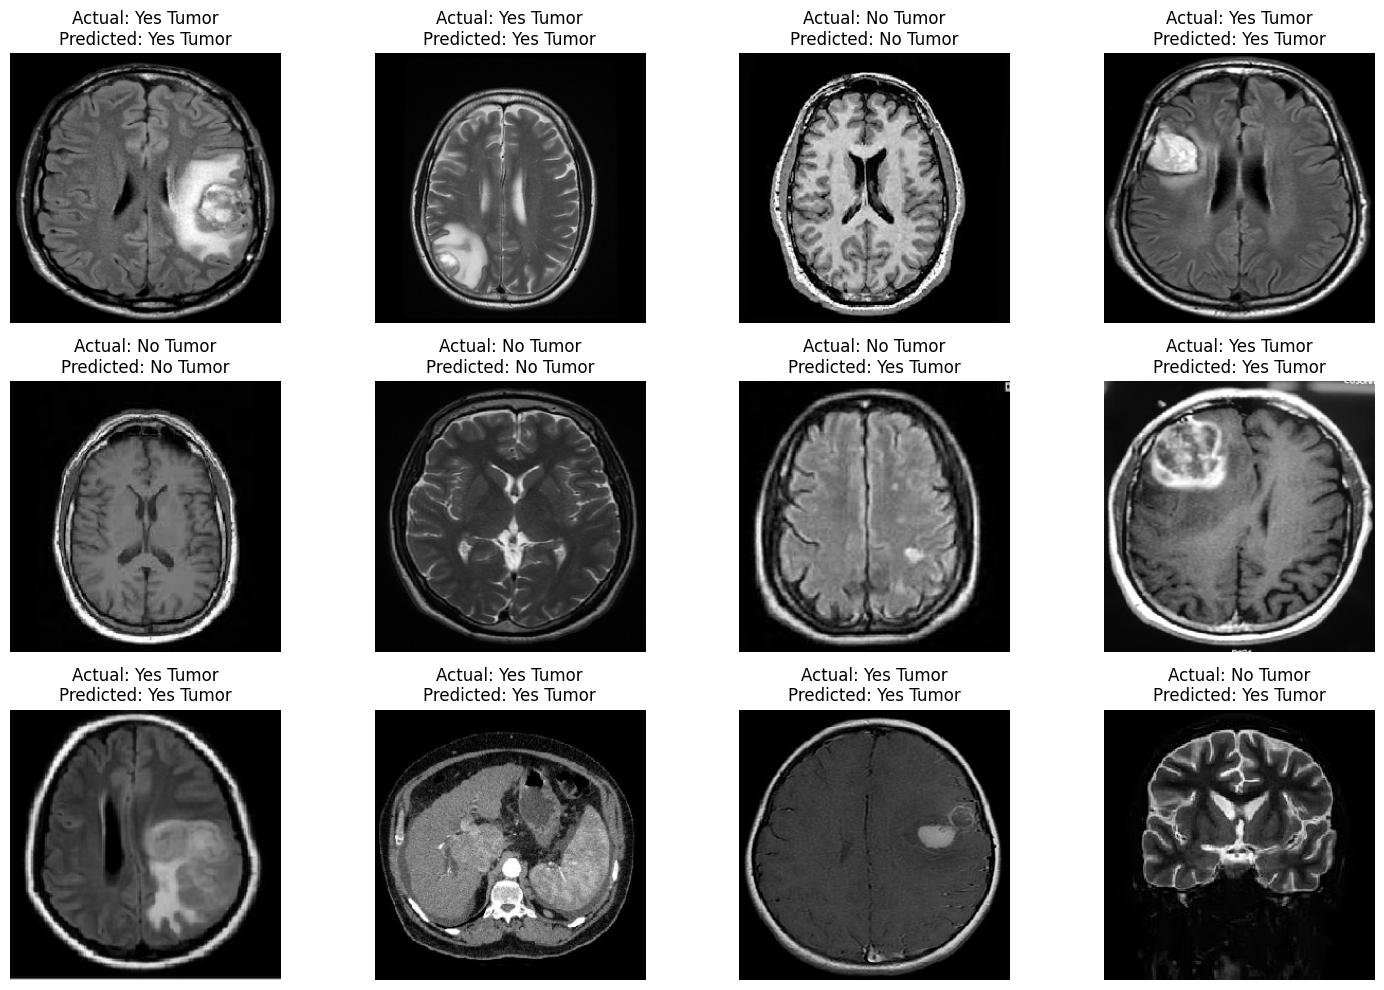

In [21]:
# Fetch a batch of test data from the test dataset generator (test_ds)
x_test, y_test = next(iter(test_ds))
num_images_to_display = 12  # Number of images to display
x_test = x_test[:num_images_to_display]  # Limit to the number of images to display
y_test = y_test[:num_images_to_display]  # Limit to the number of images to display

# Get predictions for the batch of test images
pred = model.predict(x_test)
pred = (pred > 0.5).astype(int).reshape(-1)

# Define class names
classes = ['No Tumor', 'Yes Tumor']

# Number of columns for the subplot grid
num_columns = 4

# Number of rows calculated based on the number of images and columns
num_rows = (num_images_to_display + num_columns - 1) // num_columns

# Plot the images with actual and predicted labels
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i < len(x_test):
        ax.imshow(x_test[i])
        actual_label = classes[int(y_test[i])]  # Convert y_test to int index
        predicted_label = classes[pred[i]]  # Use pred directly as it's already converted
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

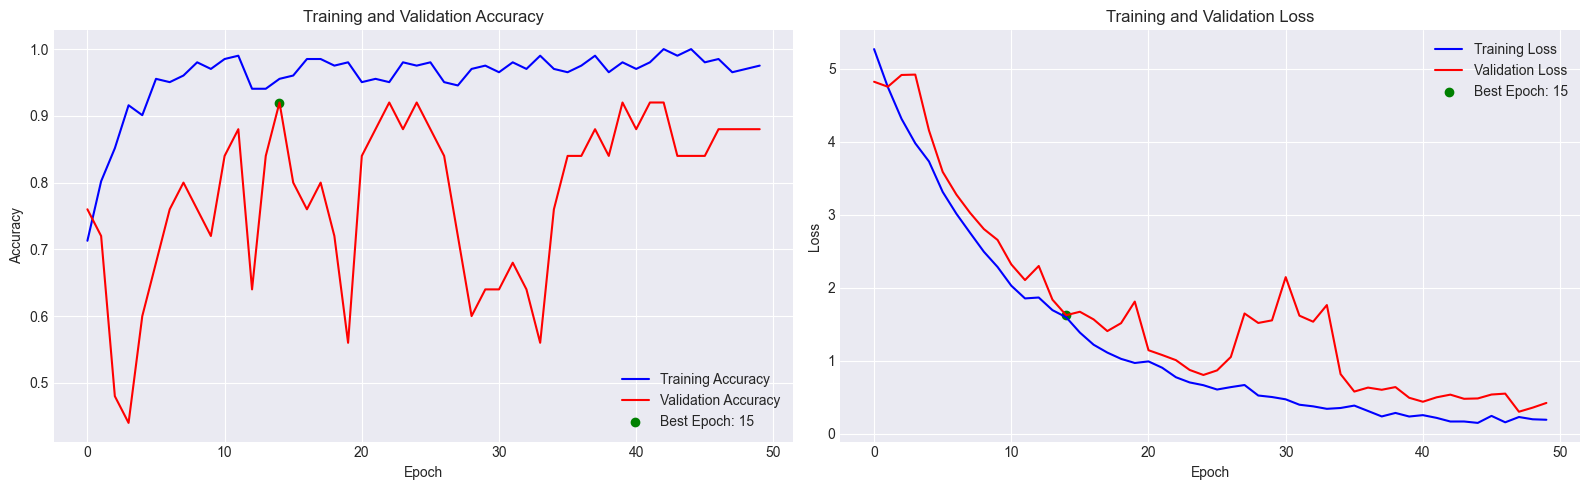

In [34]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-v0_8-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

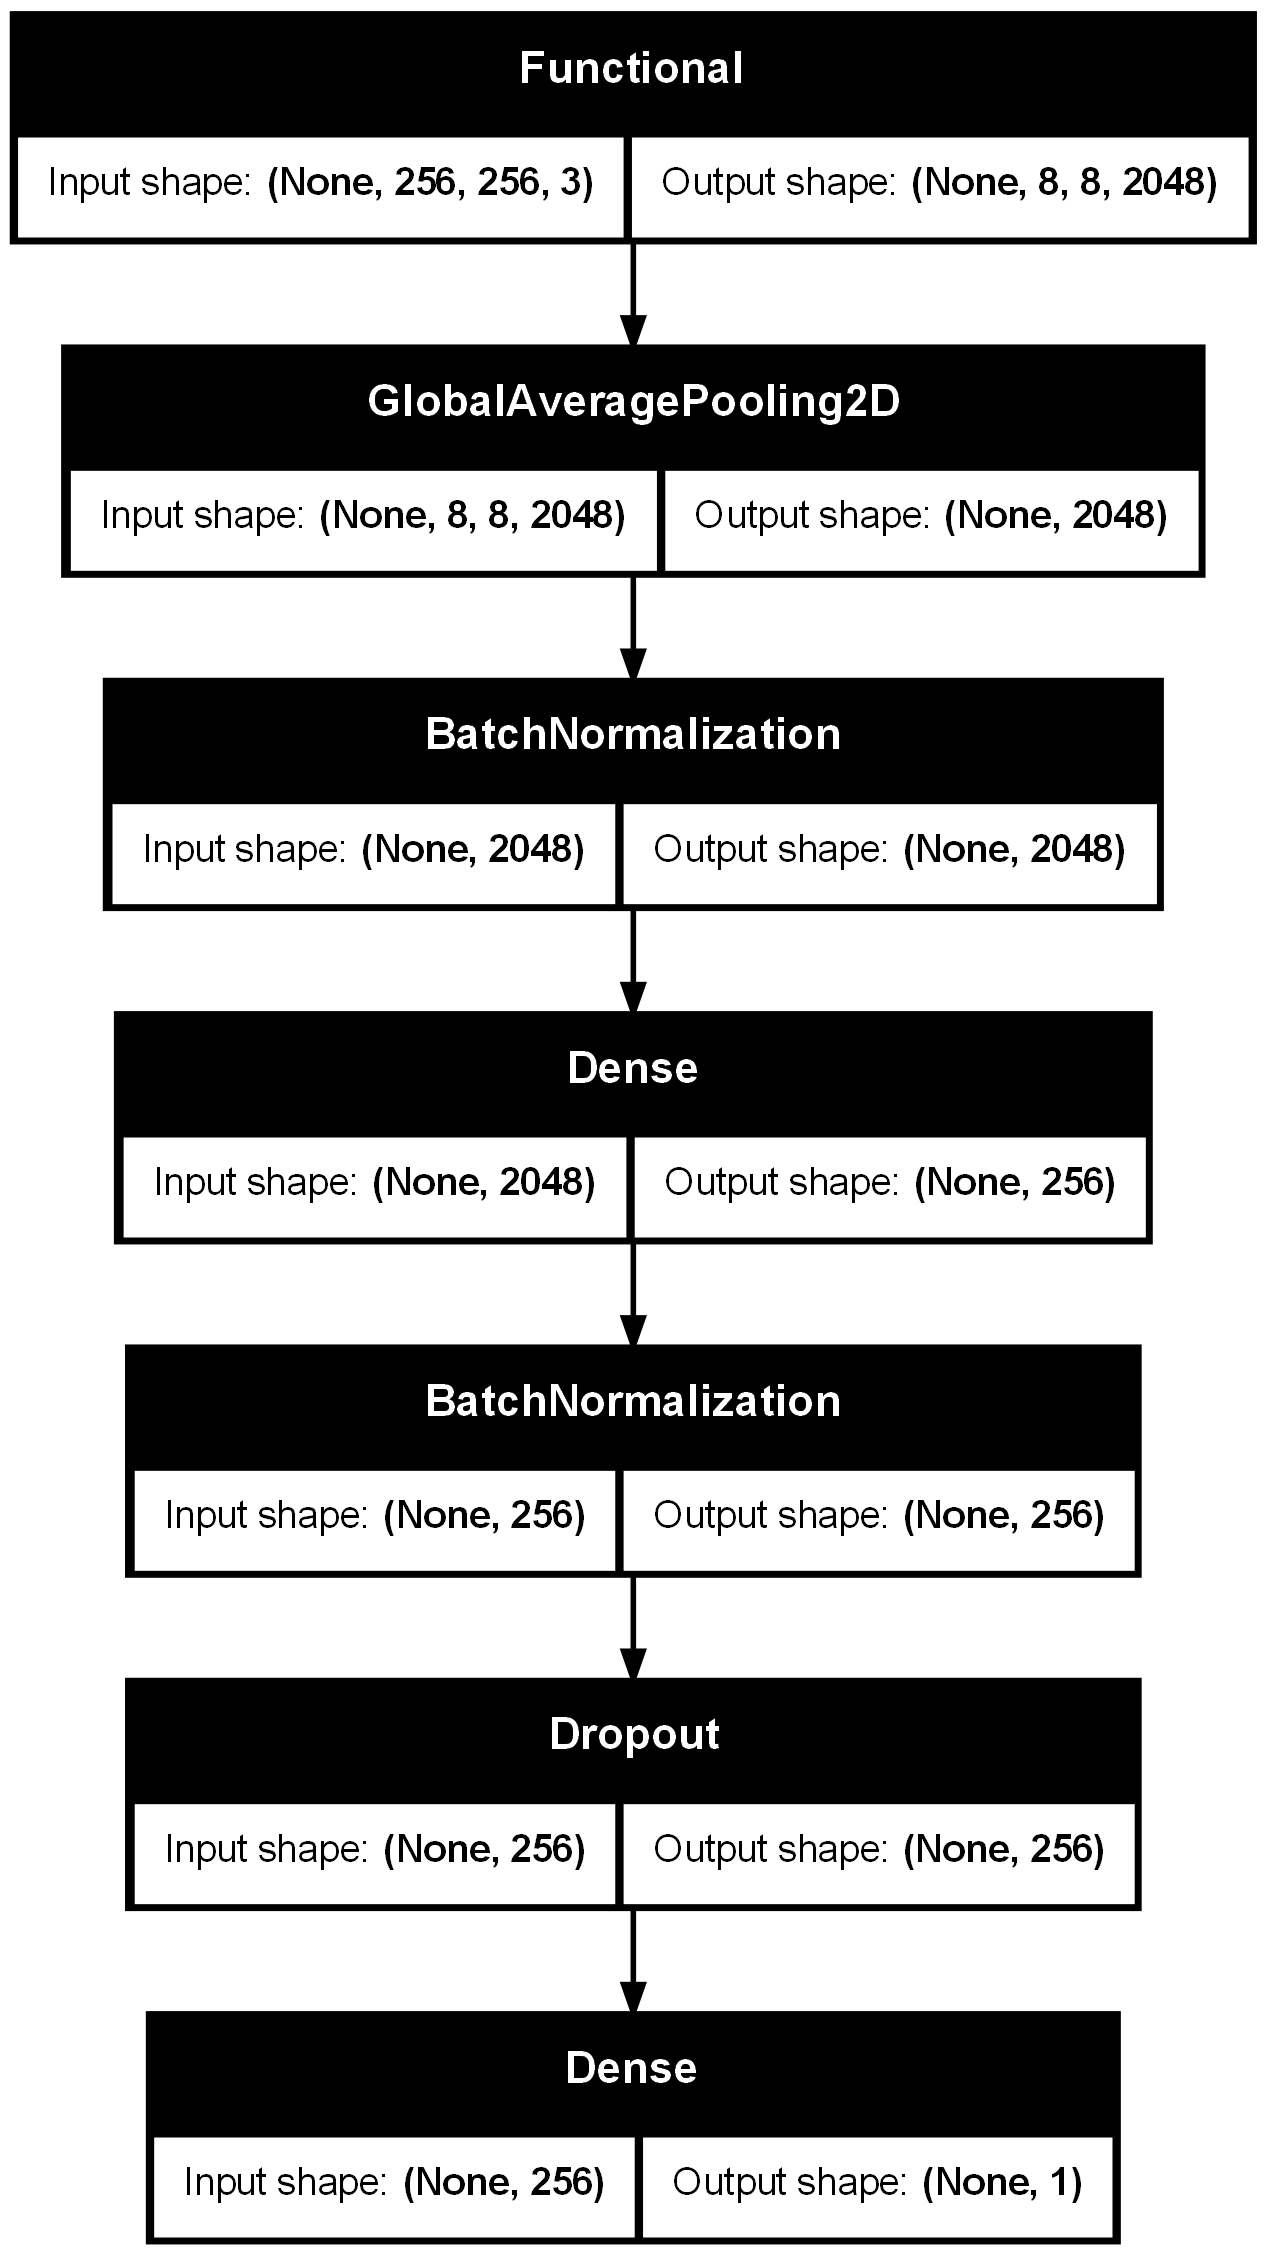

In [27]:
keras.utils.plot_model(model, to_file='tf_model.png', show_shapes=True)